# COMP 9414 - 2024 Term 2 Assignment 1

# Part 1 Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import random
import time

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, f1_score, precision_score, recall_score,ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [2]:
df = pd.read_excel("AirQualityUCI _ Students.xlsx")

In [3]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


## 1.1 Imputation for Missing Values

> Imputing missing values using the most recent previous value instead of the mean, since the dataframe represents a time series with some autocorrelation.

In [4]:
# Identify columns with missing values (-200)
columns_with_missingvalue = df.columns[(df == -200).any()]

# Function to replace -200 with the most recent previous value that is not -200
def impute_with_previous_value(df, column):
    previous_value = None
    for idx in df.index:
        if df.at[idx, column] == -200:
            if previous_value is not None:
                df.at[idx, column] = previous_value
        else:
            previous_value = df.at[idx, column]

# Apply the imputation function to each column with missing values
for column in columns_with_missingvalue:
    impute_with_previous_value(df, column)


In [5]:
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000
mean,2.090596,1098.690865,267.723857,10.214013,943.001575,240.975078,832.301498,109.145765,1451.578069,1030.483040,18.273183,48.647842,1.013274
std,1.463988,218.045262,70.994829,7.594867,270.650965,207.323146,254.307798,47.702735,348.123481,414.445086,8.935864,17.237109,0.406431
min,0.100000,647.250000,7.000000,0.149048,383.250000,4.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.175000,0.184679
25%,1.000000,935.750000,275.000000,4.401596,732.500000,97.000000,653.750000,72.050000,1224.437500,722.687500,11.481250,35.481250,0.715683
50%,1.700000,1060.250000,275.000000,8.279845,910.625000,174.000000,806.500000,101.700000,1458.750000,963.750000,17.625000,48.612500,0.982490
75%,2.800000,1233.500000,275.000000,14.050153,1118.250000,320.000000,966.437500,137.000000,1676.250000,1286.500000,24.375000,61.593750,1.315551
max,11.900000,2007.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,87.174999,2.231036


## 1.2 Data Visualization

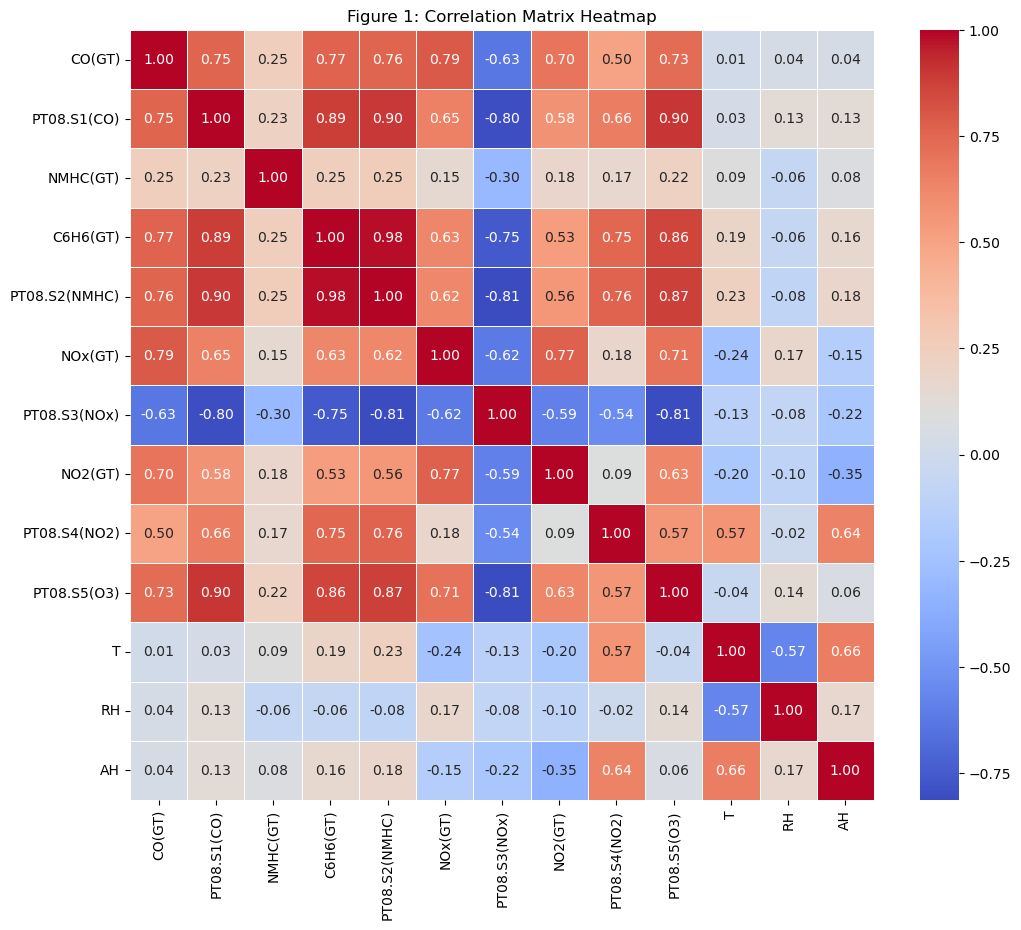

In [6]:
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Figure 1: Correlation Matrix Heatmap')
plt.show()

> Despite the low correlations between Temperature, Relative Humidity, Absolute, and our target variables, we observed that the model's stability improves significantly after 40 epochs during training and validation. Therefore, we have decided to retain these features in our models. We can also find NMHC(GT) has a low correlation to others.



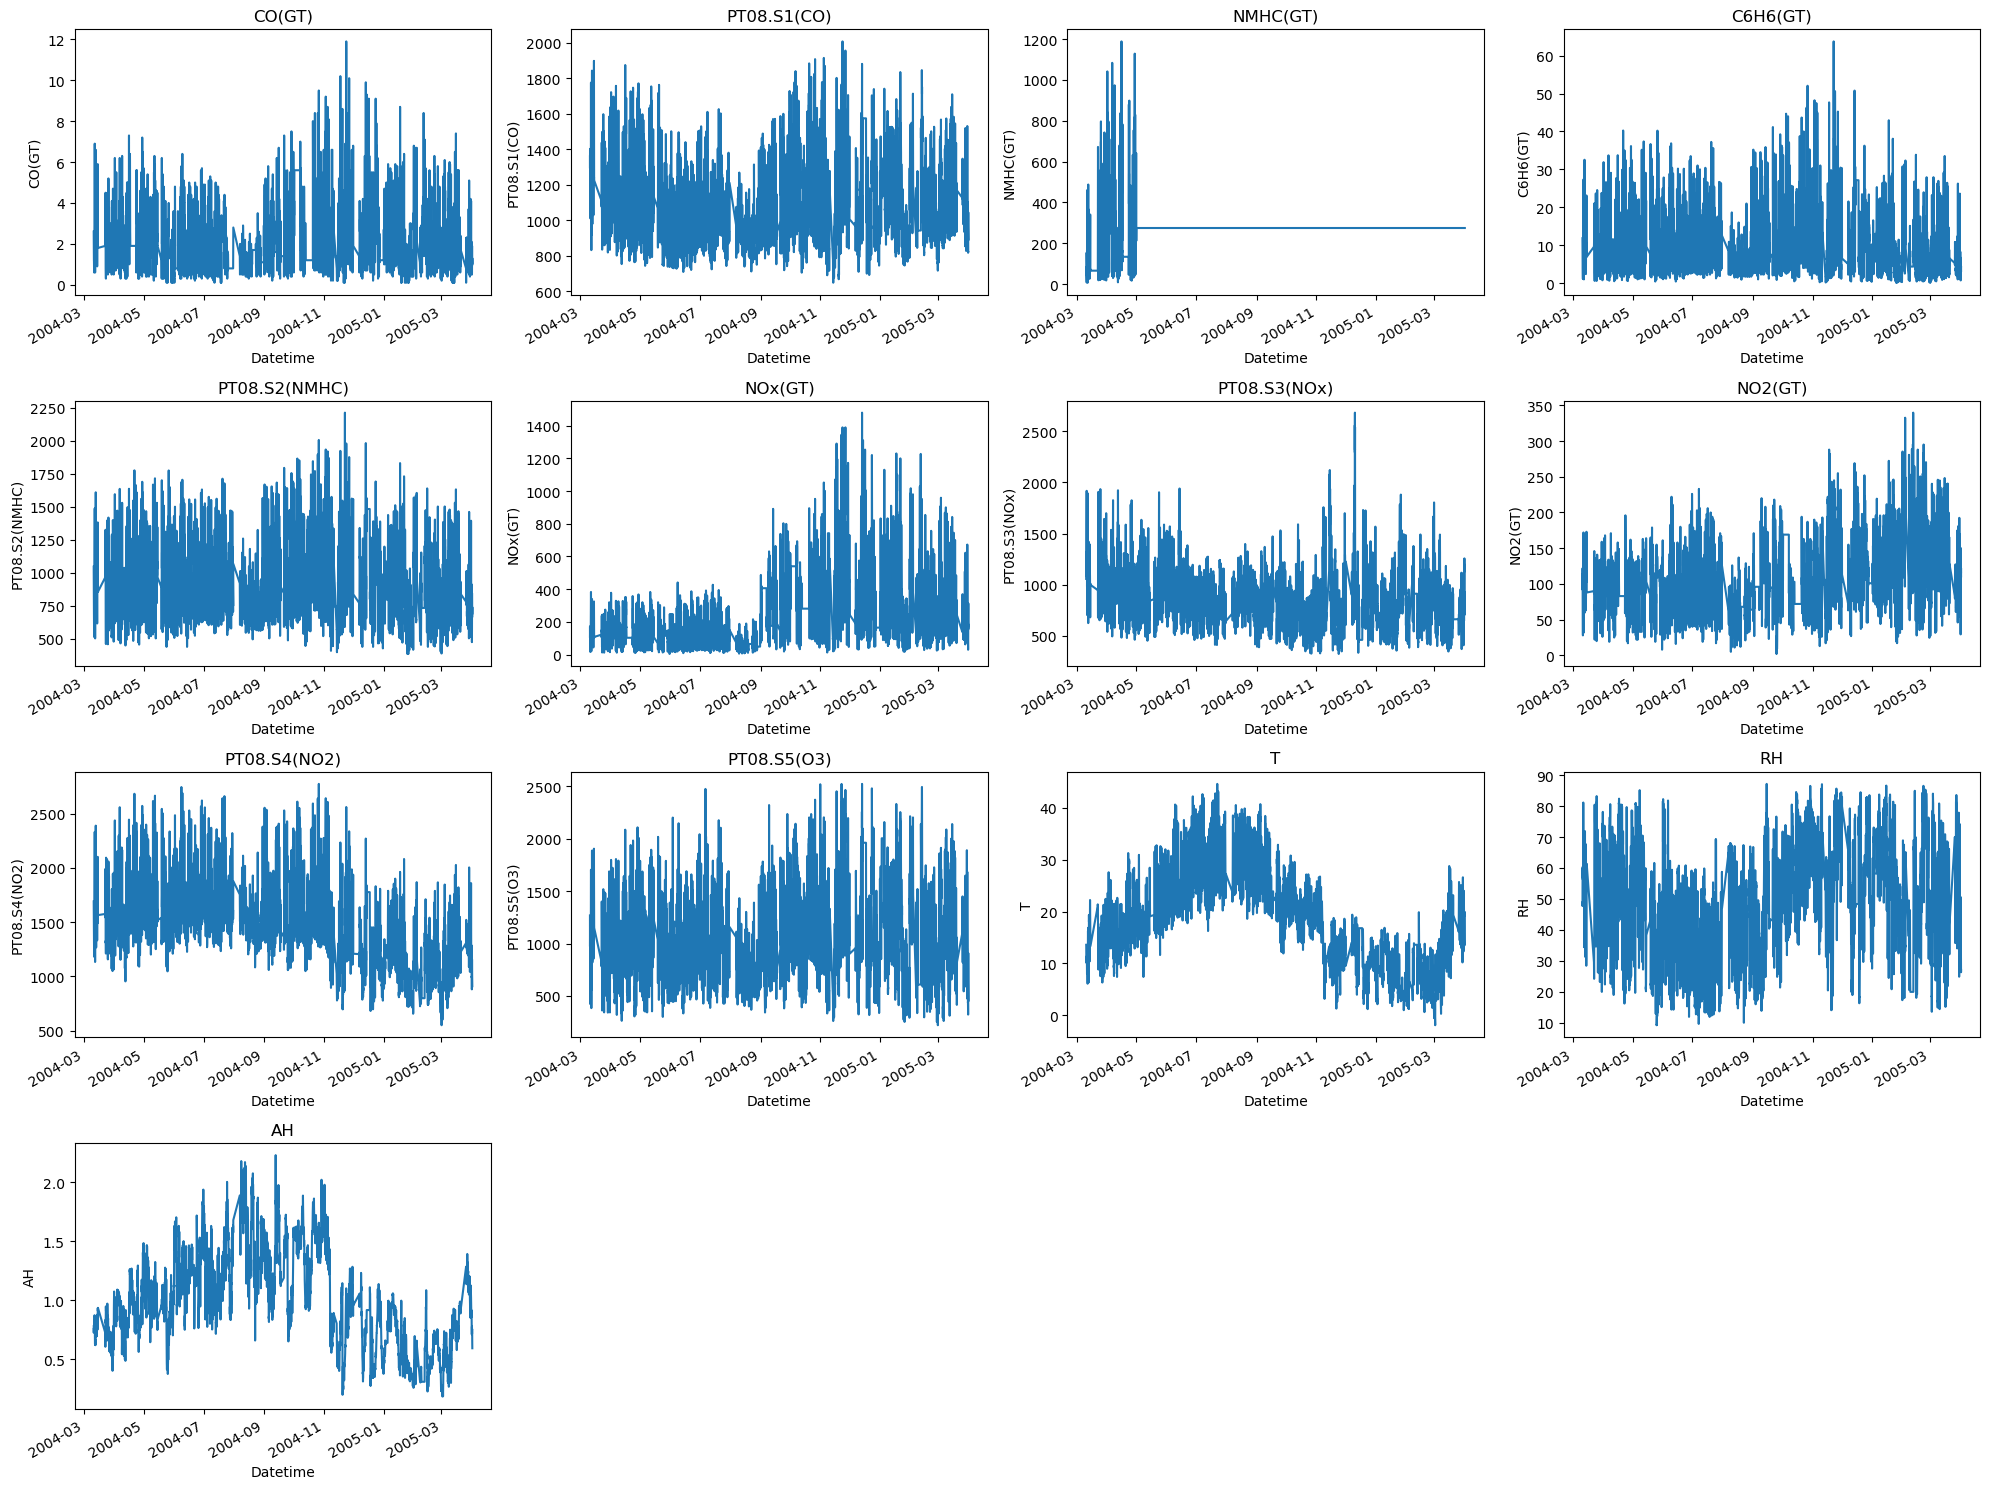

In [7]:
# Combine Date and Time into a single datetime column for plot line grpahs
df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df.set_index('datetime', inplace=True)

# Drop the original Date and Time columns
df_plot = df.drop(columns=['Date', 'Time'])

# Define the columns to plot
columns_to_plot = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 
                   'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 
                   'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Create subplots with a 4x4 grid
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
axes = axes.flatten()

# Plot each variable in its own subplot
for i, column in enumerate(columns_to_plot):
    df_plot[column].plot(ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel('Datetime')
    axes[i].set_ylabel(column)

# Hide any unused subplots
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

> There is no variation in the NMHC(GT) record, which is unusual. This is caused by a sensor malfunction that results in many missing data points.


In [8]:
df = df.drop("NMHC(GT)", axis=1)

In [9]:
df = df.reset_index()
df = df.drop("datetime",axis=1)
df_hist = df.copy() # For reference section

## 1.3 Imputation for Outliers

In [10]:
# Calculate the variation range for each column
variation_summary = df.describe().loc[['min', 'max']]
variation_summary.loc['range'] = variation_summary.loc['max'] - variation_summary.loc['min']

pd.options.display.float_format = '{:.2f}'.format
print(f"Variation Range Summary:\n",variation_summary)

Variation Range Summary:
        CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  \
min      0.10       647.25      0.15         383.25     4.00        322.00   
max     11.90      2007.75     63.74        2214.00  1479.00       2682.75   
range   11.80      1360.50     63.59        1830.75  1475.00       2360.75   

       NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH   AH  
min       2.00        551.00       221.00 -1.90  9.18 0.18  
max     339.70       2775.00      2522.75 44.60 87.17 2.23  
range   337.70       2224.00      2301.75 46.50 78.00 2.05  


In [11]:
df_outlier = df.drop(["Date","Time"],axis=1)

# Function to detect outliers using Interquartile range (IQR)
def detect_outliers_iqr(df):
    outliers = pd.DataFrame()
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers = pd.concat([outliers, column_outliers]) # Concatenate the two DataFrames along rows
    return outliers.drop_duplicates()

# Detect outliers
outliers = detect_outliers_iqr(df_outlier)

> Locating and counting outliers using the definition from the following equations:

$Interquartile range (IQR) = Q3 - Q1$

$lowerbound = Q1 - 1.5 * IQR$

$upperbound = Q3 + 1.5 * IQR$

In [12]:
len(outliers)/df.shape[0]*100

11.82100981095956

> The proportion of outliers is 11.82%, which is relatively high for the dataset. Therefore, we will apply the mean to impute the outliers instead of removing all the values.


In [13]:
# Impute outliers with median values
for column in df_outlier.columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mean_value = df[column].mean()
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = mean_value

In [14]:
# Compare the variation range for variables between the original and the modified dataset

new_variation_summary = df.describe().loc[['min', 'max']]
new_variation_summary.loc['range'] = new_variation_summary.loc['max'] - new_variation_summary.loc['min']

print(f"Original Variation Range Summary:\n",variation_summary,"\n")
print(f"New Variation Range Summary:\n",new_variation_summary)

Original Variation Range Summary:
        CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  \
min      0.10       647.25      0.15         383.25     4.00        322.00   
max     11.90      2007.75     63.74        2214.00  1479.00       2682.75   
range   11.80      1360.50     63.59        1830.75  1475.00       2360.75   

       NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH   AH  
min       2.00        551.00       221.00 -1.90  9.18 0.18  
max     339.70       2775.00      2522.75 44.60 87.17 2.23  
range   337.70       2224.00      2301.75 46.50 78.00 2.05   

New Variation Range Summary:
        CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  \
min      0.10       647.25      0.15         383.25     4.00        322.00   
max      5.50      1680.00     28.50        1691.75   654.00       1434.75   
range    5.40      1032.75     28.35        1308.50   650.00       1112.75   

       NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH   AH  
mi

> Some extreme outliers were imputed using the mean, resulting in a significant reduction in the range of CO(GT), C6H6(GT), PT08.S2(NMHC), NOx(GT), and PT08.S3(NOx).

> 

In [15]:
#Completed EDA and prepared the dataframe for constructing models
class_df = df.copy()
regress_df = df.copy()

# Part 2 Classification of Carbon Monoxide (CO) Concentration

## 2.1 Data Preprocessing

In [16]:
# Assign 1 to CO values greater than the mean and 0 otherwise
co_mean = class_df["CO(GT)"].mean()
class_df['CO(GT)'] = (class_df['CO(GT)'] > co_mean).astype(int)
class_df['CO(GT)'].value_counts()

0    4798
1    3560
Name: CO(GT), dtype: int64

In [17]:
#convert date into year, month and day
class_df['year'] = class_df['Date'].dt.year
class_df['month'] = class_df['Date'].dt.month
class_df['day'] = class_df['Date'].dt.day

class_df = class_df.drop(columns=["Date"])

In [18]:
X = class_df.drop(columns=["CO(GT)"], axis=1)
y = class_df["CO(GT)"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=2024)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=0.2, stratify=y_train, random_state=2024)

In [20]:
X_train.columns

Index(['Time', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH',
       'AH', 'year', 'month', 'day'],
      dtype='object')

In [21]:
ord_vars =["Time","year","month","day"]
ct = make_column_transformer(
    (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ord_vars),
    remainder=make_pipeline(StandardScaler()),
    verbose_feature_names_out=False
)

In [22]:
X_train_ct = ct.fit_transform(X_train)
X_valid_ct =ct.transform(X_valid)
X_test_ct=ct.transform(X_test)

X_train_ct.shape

(5014, 15)

## 2.2 Constructing Model

In [23]:
def create_modelC(seed=2024):
    random.seed(seed)
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(Input(X_train_ct.shape[1:][0]))
    model.add(Dense(16, "leaky_relu"))
    model.add(Dense(8, "leaky_relu"))
    model.add(Dense(8, "leaky_relu"))
    model.add(Dense(1,"sigmoid"))
    return model


> The `create_modela` function constructs a neural network model using TensorFlow and Keras. It initializes the model with a specific seed for reproducibility. The model consists of an input layer, three hidden layers with Leaky ReLU activation functions (16, 8, and 8 units respectively), and an output layer with a sigmoid activation function for binary classification.


In [24]:
model = create_modelC()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                256       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 473 (1.85 KB)
Trainable params: 473 (1.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


> Rule of Thumb for Model Complexity

A general rule of thumb for the number of parameters in a model is:

$ \text{Number of parameters} < \frac{\text{number of samples}}{10} $

Given: Number of samples = 5014

The maximum number of parameters should be:

$\text{Max number of parameters} = \frac{5014}{10} = 501.4 $

Therefore, the maximum number of parameters for our model should be approximately 501. In our model, we applied 473 parameters.

In [25]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", metrics.AUC()])
#es= EarlyStopping(patience=50, restore_best_weights=True, monitor="val_auc", verbose=1)

start_time_fit = time.time()
history = model.fit(X_train_ct,y_train, epochs=200, verbose=0,
          validation_data=(X_valid_ct,y_valid));

end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit
print(f"Model fitting time: {fit_time} seconds")

Model fitting time: 12.59604787826538 seconds


> Setting epochs to 200 to balance model complexity and prevent overfitting

## 2.3 Model Evaluation

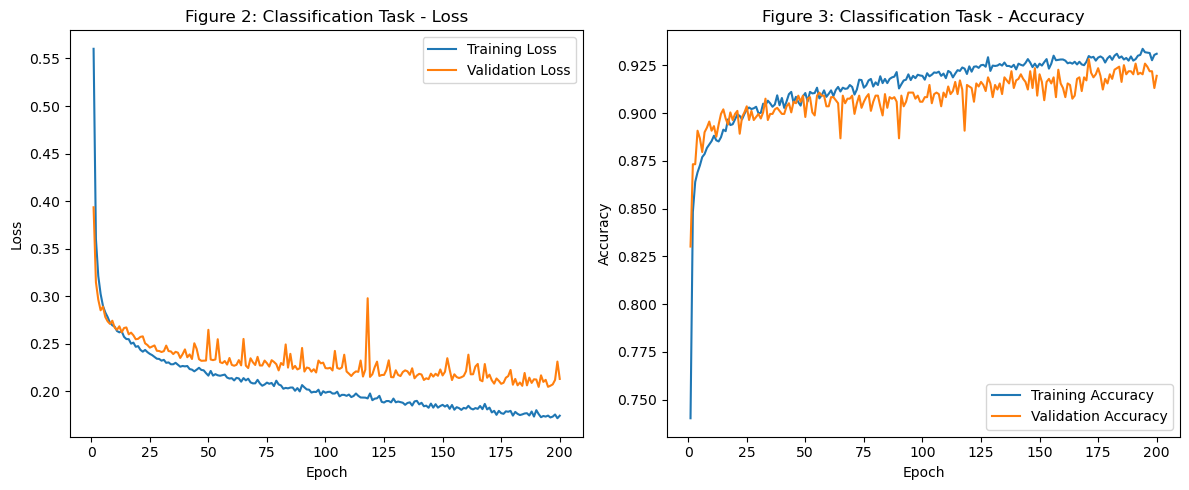

In [26]:
# Plotting the loss and accuracy
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Figure 2: Classification Task - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Figure 3: Classification Task - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Evaluate the model on validation and test sets
valid_loss, valid_accuracy, valid_auc = model.evaluate(X_valid_ct, y_valid, verbose=0)
test_loss, test_accuracy, test_auc = model.evaluate(X_test_ct, y_test, verbose=0)

# Make predictions
y_pred = model.predict(X_test_ct, verbose=0)
y_pred = (y_pred > 0.5).astype("int32")

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Validation Accuracy: {valid_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Validation Accuracy: 91.95%
Test Accuracy: 92.44%


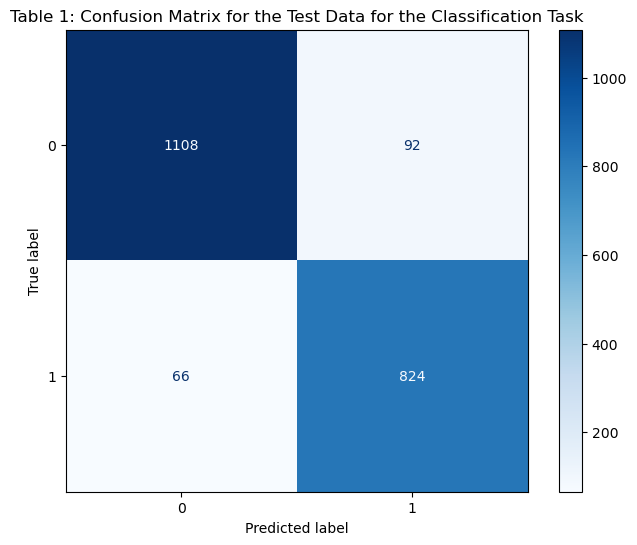

In [28]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Customizing the plot to resemble the table format
ax.set_title('Table 1: Confusion Matrix for the Test Data for the Classification Task')
plt.show()

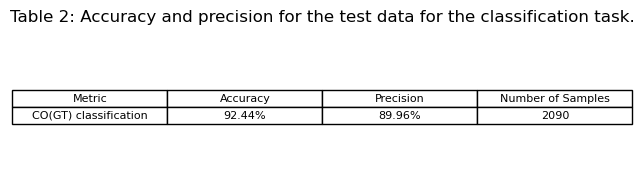

In [29]:
table_data = {
    "Metric": ["CO(GT) classification"],
    "Accuracy": [f"{test_accuracy * 100:.2f}%"],
    "Precision": [f"{precision * 100:.2f}%"],
    "Number of Samples": [len(y_test)]
}

report = pd.DataFrame(table_data)

# Plot the table
fig, ax = plt.subplots(figsize=(8, 2)) 
ax.axis('off')
ax.table(cellText=report.values, colLabels=report.columns, cellLoc='center', loc='center')
plt.title("Table 2: Accuracy and precision for the test data for the classification task.")
plt.show()


# Part 3 Regression for Predicting the Concentration of Nitrogen Oxides (NOx)

## 3.1 Data Preprocessing

In [30]:
#convert date into year, month and day
regress_df['year'] = regress_df['Date'].dt.year
regress_df['month'] = regress_df['Date'].dt.month
regress_df['day'] = regress_df['Date'].dt.day

regress_df = regress_df.drop(columns=["Date"])

In [31]:
Xr = regress_df.drop("NOx(GT)", axis=1)
yr = regress_df["NOx(GT)"]

In [32]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.25, random_state=2024)
Xr_train, Xr_valid, yr_train, yr_valid = train_test_split(Xr_train, yr_train,test_size=0.2, random_state=2024)

In [33]:
ord_vars =["Time","year","month","day"]
rt = make_column_transformer(
    (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ord_vars),
    remainder=make_pipeline(StandardScaler()),
    verbose_feature_names_out=False
)

In [34]:
Xr_train_rt = rt.fit_transform(Xr_train)
Xr_valid_rt =rt.transform(Xr_valid)
Xr_test_rt=rt.transform(Xr_test)

Xr_train_rt.shape

(5014, 15)

## 3.2 Constructing Model

In [35]:
def create_modelR(seed=2024):
    random.seed(seed)
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(Input(Xr_train_rt.shape[1:][0]))
    model.add(Dense(16, "leaky_relu"))
    model.add(Dense(8, "leaky_relu"))
    model.add(Dense(8, "leaky_relu"))
    model.add(Dense(1, activation='relu'))  

    return model


> The `create_modelR` function constructs a neural network model using TensorFlow and Keras. It initializes the model with a specific seed for reproducibility. The model consists of an input layer, three hidden layers with Leaky ReLU activation functions (16, 8, and 8 units respectively), and an output layer with a ReLU activation function for regression tasks, ensuring no negative predictions."


In [36]:
model_regress = create_modelR()
model_regress.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                256       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 473 (1.85 KB)
Trainable params: 473 (1.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
model_regress.compile(optimizer="adam", loss="mse", metrics=["mae"])

start_time_fit = time.time()
history_regress = model_regress.fit(Xr_train_rt,yr_train, epochs=100, verbose=0,
          validation_data=(Xr_valid_rt,yr_valid));

end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit
print(f"Model fitting time: {fit_time} seconds")

Model fitting time: 5.459600925445557 seconds


## 3.3 Model Evaluation

In [38]:
# Predict on validation data
yr_valid = yr_valid.values
yr_pred = model_regress.predict(Xr_valid_rt, verbose=0)

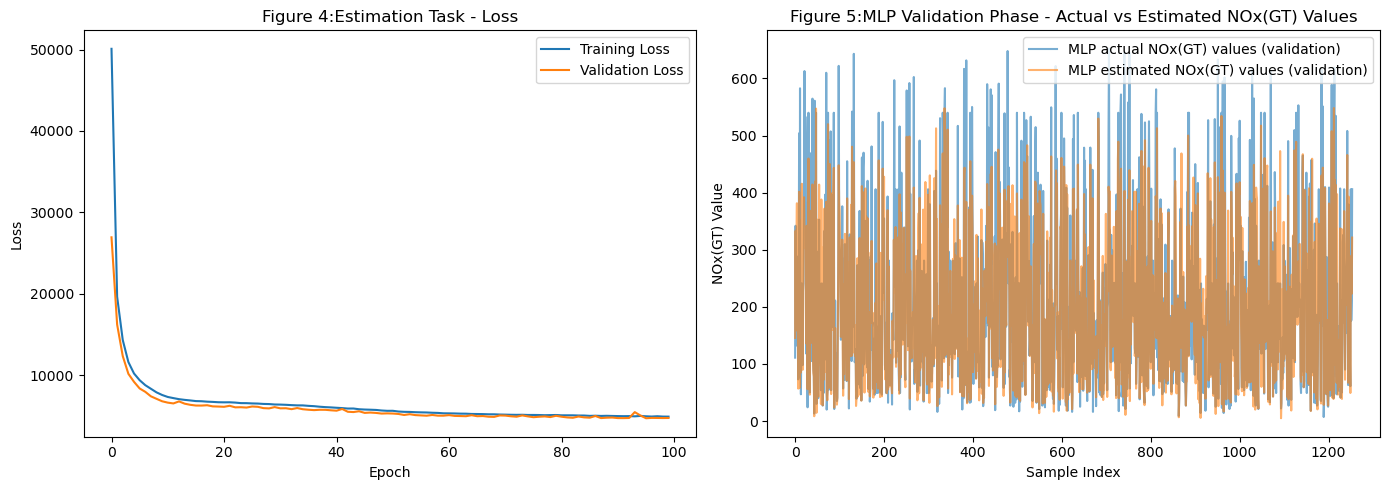

In [39]:
plt.figure(figsize=(14, 5))

# Plot the loss for training and validation data
plt.subplot(1, 2, 1)
plt.plot(history_regress.history['loss'], label='Training Loss')
plt.plot(history_regress.history['val_loss'], label='Validation Loss')
plt.title('Figure 4:Estimation Task - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the actual vs estimated values
plt.subplot(1, 2, 2)
plt.plot(yr_valid, label='MLP actual NOx(GT) values (validation)', alpha=0.6)
plt.plot(yr_pred, label='MLP estimated NOx(GT) values (validation)', alpha=0.6)
plt.title('Figure 5:MLP Validation Phase - Actual vs Estimated NOx(GT) Values')
plt.xlabel('Sample Index')
plt.ylabel('NOx(GT) Value')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

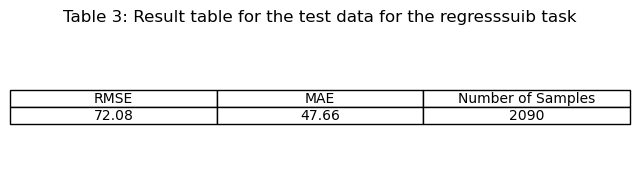

In [40]:
test_loss, test_mae = model_regress.evaluate(Xr_test_rt, yr_test, verbose=0)

# Calculate RMSE from MSE
test_rmse = np.sqrt(test_loss)

# Create a dictionary with the results
results = {
    'RMSE': [round(test_rmse,2)],
    'MAE': [round(test_mae,2)],
    'Number of Samples': str(len(yr_test))
}

results_df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(8, 2))  # Adjust the size as needed
ax.axis('off')
ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
plt.title("Table 3: Result table for the test data for the regresssuib task")
plt.show()

# Part 4 Script for Generalization Dataset

In [41]:
ls

AirQualityUCI _ Students.xlsx      Generalization Dataset.xlsx
COMP9414_Assignment_1_NN_24T2.pdf  test_newmodel.ipynb
Draft/                             z5403980_keithtang.ipynb


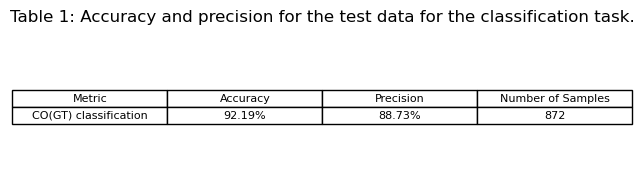

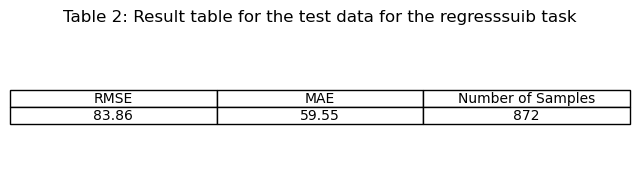

In [42]:
gd = pd.read_excel("Generalization Dataset.xlsx") #import generalizartion dataset

columns_with_missingvaluegd = gd.columns[(gd == -200).any()]

# Function to replace -200 with the most recent previous value that is not -200
def impute_with_previous_value(gd, column):
    previous_value = None
    for idx in gd.index:
        if gd.at[idx, column] == -200:
            if previous_value is not None:
                gd.at[idx, column] = previous_value
        else:
            previous_value = gd.at[idx, column]

# Apply the imputation function to each column with missing values
for column in columns_with_missingvaluegd:
    impute_with_previous_value(gd, column)
    
gd = gd.drop("NMHC(GT)", axis=1)
gd_outlier = gd.drop(["Date","Time"],axis=1)

# Function to detect outliers using Interquartile range (IQR)
def detect_outliers_iqr(gd):
    outliers = pd.DataFrame()
    for column in gd.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        column_outliers = gd[(gd[column] < lower_bound) | (gd[column] > upper_bound)]
        outliers = pd.concat([outliers, column_outliers]) # Concatenate the two DataFrames along rows
    return outliers.drop_duplicates()

# Detect outliers
outliers = detect_outliers_iqr(gd_outlier)

for column in gd_outlier.columns:
    Q1 = gd[column].quantile(0.25)
    Q3 = gd[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mean_value = gd[column].mean()
    gd.loc[(df[column] < lower_bound) | (gd[column] > upper_bound), column] = mean_value
    
#Completed EDA and prepared the dataframe for constructing models
class_gd = gd.copy()
regress_gd = gd.copy()

# Assign 1 to CO values greater than the mean and 0 otherwise
co_mean = class_gd["CO(GT)"].mean()
class_gd['CO(GT)'] = (class_gd['CO(GT)'] > co_mean).astype(int)
class_gd['CO(GT)'].value_counts()

#convert date into year, month and day
class_gd['year'] = class_gd['Date'].dt.year
class_gd['month'] = class_gd['Date'].dt.month
class_gd['day'] = class_gd['Date'].dt.day
class_gd = class_gd.drop(columns=["Date"])

Xcgd = class_gd.drop(columns=["CO(GT)"], axis=1)
ycgd = np.array(class_gd["CO(GT)"])
Xcgd_ct = ct.transform(Xcgd)

# Evaluate the model on validation and test sets
test_loss, test_accuracy, test_auc = model.evaluate(Xcgd_ct, ycgd, verbose=0)

# Make predictions
y_pred_c = model.predict(Xcgd_ct, verbose=0)
y_pred_c = (y_pred_c > 0.5).astype("int32")

# Calculate precision, recall, and F1 score
precision = precision_score(ycgd, y_pred_c)
recall = recall_score(ycgd, y_pred_c)
f1 = f1_score(ycgd, y_pred_c)

table_data = {
    "Metric": ["CO(GT) classification"],
    "Accuracy": [f"{test_accuracy * 100:.2f}%"],
    "Precision": [f"{precision * 100:.2f}%"],
    "Number of Samples": [len(ycgd)]
}

# Create a DataFrame
report = pd.DataFrame(table_data)

# Plot the table
fig, ax = plt.subplots(figsize=(8, 2)) 
ax.axis('off')
ax.table(cellText=report.values, colLabels=report.columns, cellLoc='center', loc='center')

# Set the title
plt.title("Table 1: Accuracy and precision for the test data for the classification task.")
plt.show()

#regression
regress_gd['year'] = regress_gd['Date'].dt.year
regress_gd['month'] = regress_gd['Date'].dt.month
regress_gd['day'] = regress_gd['Date'].dt.day
regress_gd = regress_gd.drop(columns=["Date"])

Xrgd = regress_gd.drop("NOx(GT)", axis=1)
yrgd = np.array(regress_gd["NOx(GT)"])
Xcgd_rt = rt.transform(Xrgd)

test_loss, test_mae = model_regress.evaluate(Xcgd_rt, yrgd, verbose=0)

# Calculate RMSE from MSE
test_rmse = np.sqrt(test_loss)

# Create a dictionary with the results
resultsgd = {
    'RMSE': [round(test_rmse,2)],
    'MAE': [round(test_mae,2)],
    'Number of Samples': str(len(yrgd))
}

results_gd = pd.DataFrame(resultsgd)
fig, ax = plt.subplots(figsize=(8, 2))  # Adjust the size as needed
ax.axis('off')
ax.table(cellText=results_gd.values, colLabels=results_gd.columns, cellLoc='center', loc='center')
plt.title("Table 2: Result table for the test data for the regresssuib task")
plt.show()

# Part 5 Reference for possible discussion questions

## 5.1 Histograms of Sensor Data and Environmental Variables 

In [42]:
df_hist = df_hist.drop(columns=["Date","Time"])


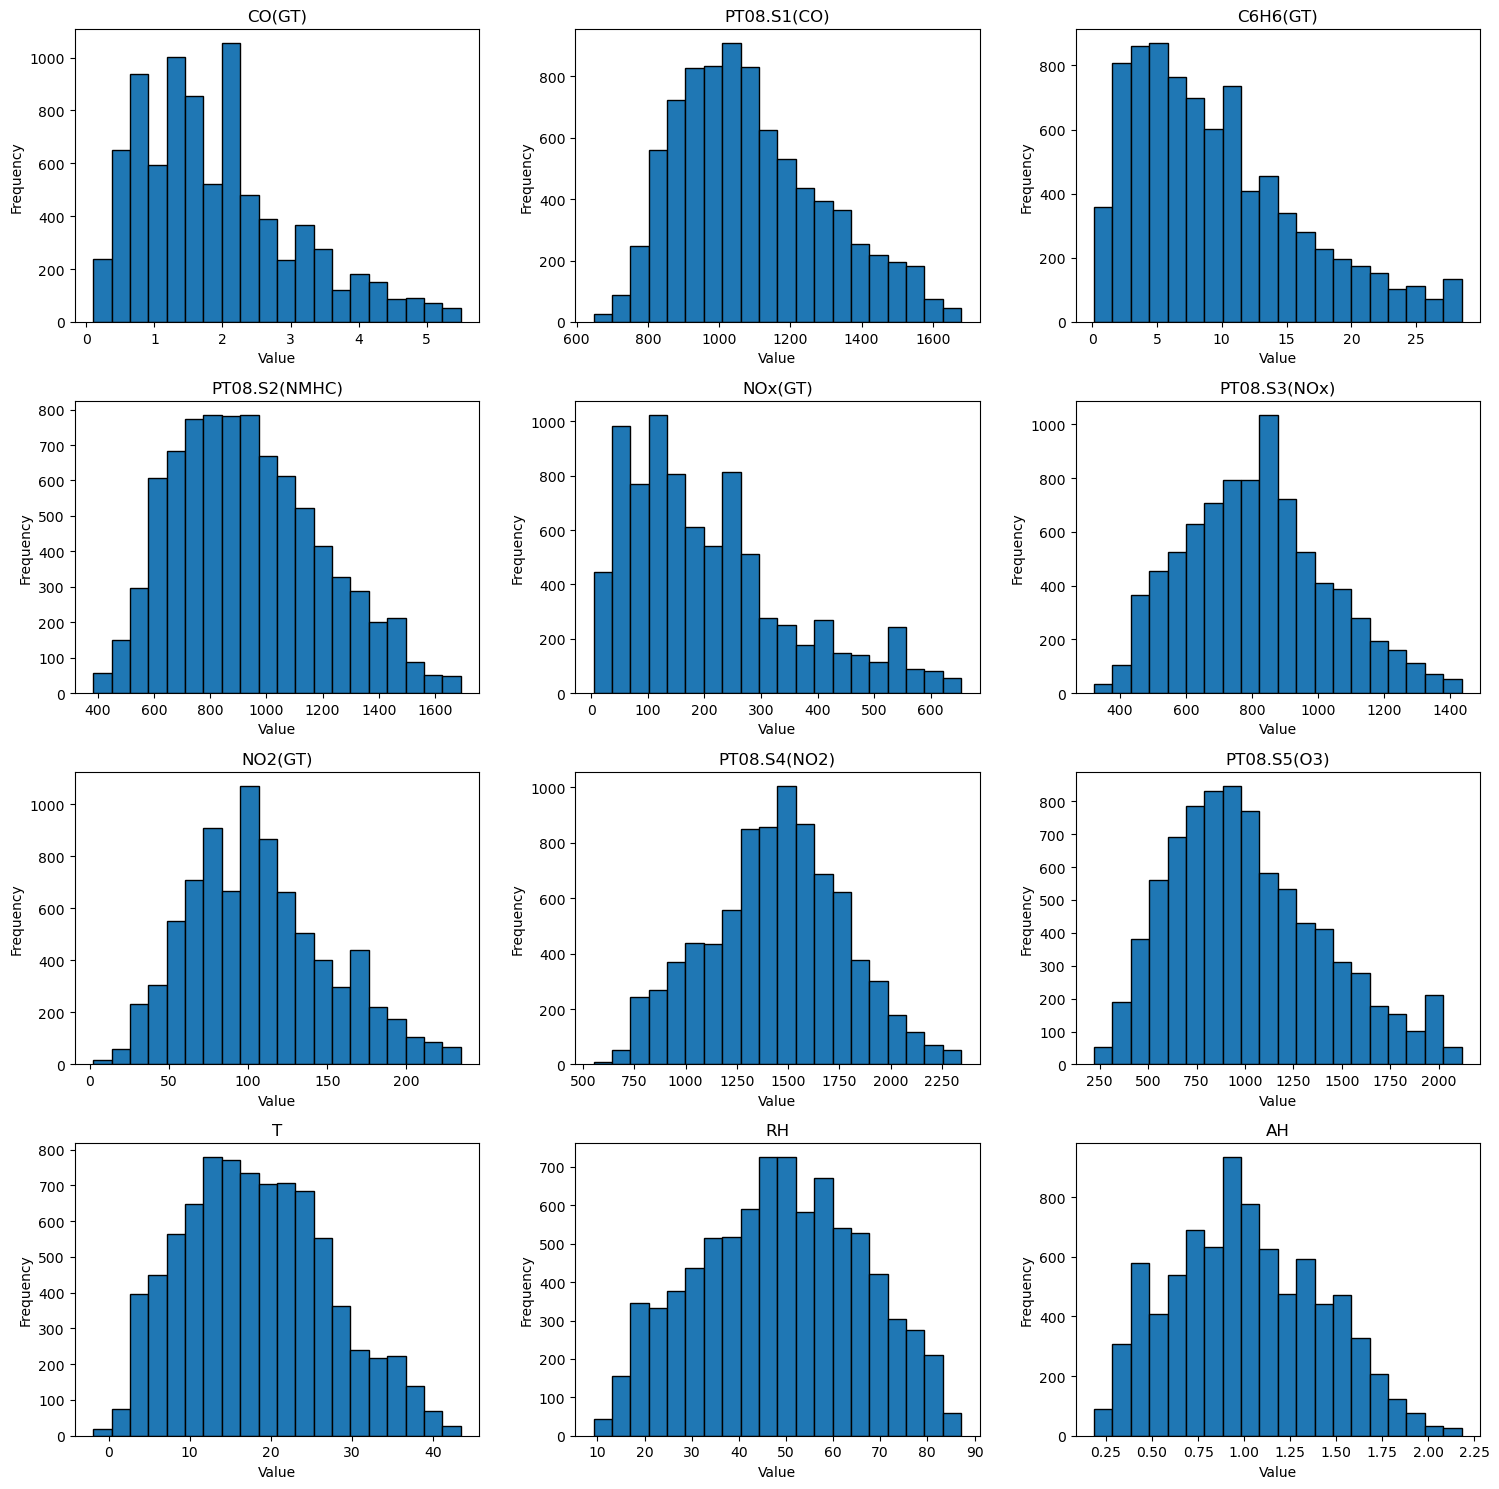

In [43]:
columns = df_hist.columns
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
axes = axes.ravel()

for idx, col in enumerate(columns):
    axes[idx].hist(df[col], bins=20, edgecolor='black')
    axes[idx].set_title(col)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5.2 5-Fold Cross Validation for Classification Model

In [44]:
X_cv = class_df.drop(columns=["CO(GT)"], axis=1)
y_cv = class_df["CO(GT)"]
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_cv, y_cv, test_size=0.25, stratify=y, random_state=2024)
ord_vars =["Time","year","month","day"]
ct_cv = make_column_transformer(
    (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ord_vars),
    remainder=make_pipeline(StandardScaler()),
    verbose_feature_names_out=False
)
X_train_ct_cv = ct_cv.fit_transform(X_train_cv)
X_test_ct_cv=ct_cv.transform(X_test_cv)
y_train_cv_np = y_train_cv.to_numpy()
X_train_ct_cv.shape

(6268, 15)

In [45]:
from sklearn.model_selection import KFold

def create_modelC_cv(seed=2024):
    random.seed(seed)
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(Input(X_train_ct_cv.shape[1:][0]))
    model.add(Dense(16, activation="leaky_relu"))
    model.add(Dense(8, activation="leaky_relu"))
    model.add(Dense(8, activation="leaky_relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model

kf = KFold(n_splits=5, shuffle=True, random_state=2024)
cv_scores = []



histories = []
start_time_fit = time.time()

for train_index, val_index in kf.split(X_train_ct_cv):
    X_train_fold, X_val_fold = X_train_ct_cv[train_index], X_train_ct_cv[val_index]
    y_train_fold, y_val_fold = y_train_cv_np[train_index], y_train_cv_np[val_index]
    
    model = create_modelC_cv()
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", metrics.AUC()])
    
    history_cv = model.fit(X_train_fold, y_train_fold, epochs=200, verbose=0,
                        validation_data=(X_val_fold, y_val_fold))
    
    histories.append(history_cv.history)
    
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    cv_scores.append(scores)
    

end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit

In [46]:
print(f"Total model fitting time: {fit_time} seconds")

# Calculate and print average cross-validation scores
cv_scores = np.array(cv_scores)
mean_scores = np.mean(cv_scores, axis=0)
std_scores = np.std(cv_scores, axis=0)
print(f"Cross-Validation Scores: Loss and Accuracy \n {cv_scores[:,:2]}")
print(f"Mean Scores: {mean_scores[:2]}")
print(f"Standard Deviation of Scores: {std_scores[:2]}")

Total model fitting time: 61.94258713722229 seconds
Cross-Validation Scores: Loss and Accuracy 
 [[0.20162947 0.93381178]
 [0.24055643 0.90510368]
 [0.19205964 0.91467303]
 [0.24047859 0.90103751]
 [0.20194286 0.90981644]]
Mean Scores: [0.2153334  0.91288849]
Standard Deviation of Scores: [0.02086746 0.01141451]


In [47]:
def aggregate_histories(histories, metric):
    all_values = np.array([h[metric] for h in histories])
    mean_values = np.mean(all_values, axis=0)
    std_values = np.std(all_values, axis=0)
    return mean_values, std_values

epochs = range(1, 201)  # Assuming 200 epochs

mean_loss, std_loss = aggregate_histories(histories, 'loss')
mean_val_loss, std_val_loss = aggregate_histories(histories, 'val_loss')
mean_accuracy, std_accuracy = aggregate_histories(histories, 'accuracy')
mean_val_accuracy, std_val_accuracy = aggregate_histories(histories, 'val_accuracy')


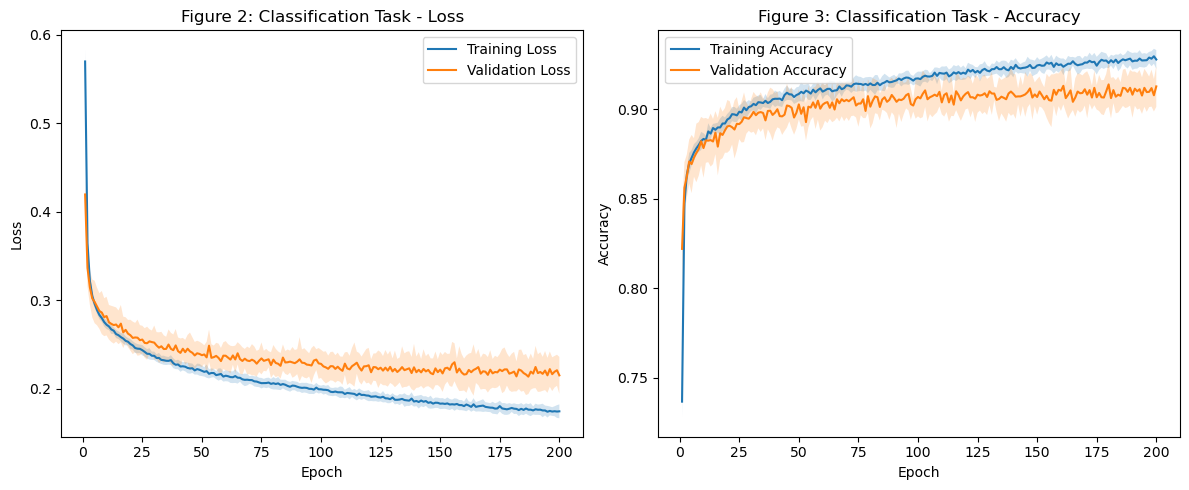

In [48]:
plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, mean_loss, label='Training Loss')
plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2)
plt.plot(epochs, mean_val_loss, label='Validation Loss')
plt.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.2)
plt.title('Figure 2: Classification Task - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, mean_accuracy, label='Training Accuracy')
plt.fill_between(epochs, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.2)
plt.plot(epochs, mean_val_accuracy, label='Validation Accuracy')
plt.fill_between(epochs, mean_val_accuracy - std_val_accuracy, mean_val_accuracy + std_val_accuracy, alpha=0.2)
plt.title('Figure 3: Classification Task - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()